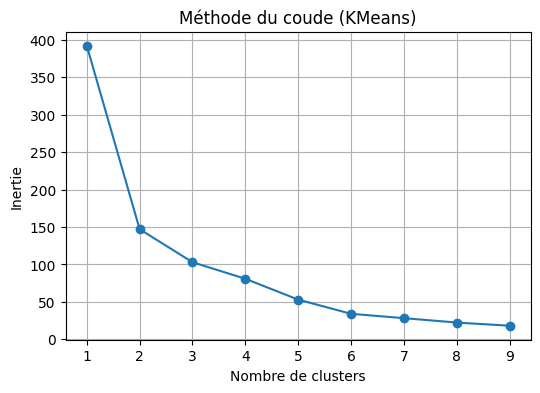

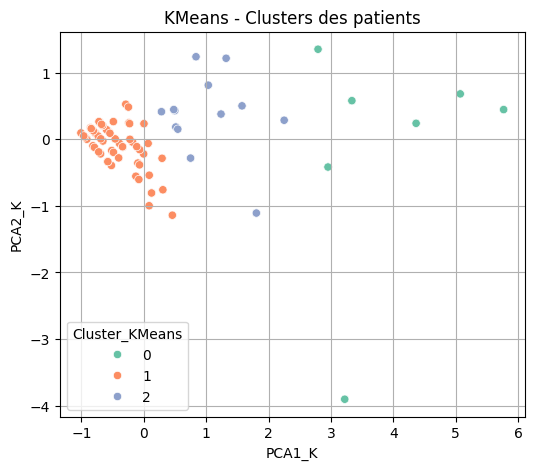

KMeans - Moyennes par cluster :
                Total_Cost  ICU_Stay
Cluster_KMeans                      
0                591300.00     20.43
1                 77919.87      1.50
2                204815.38      9.92


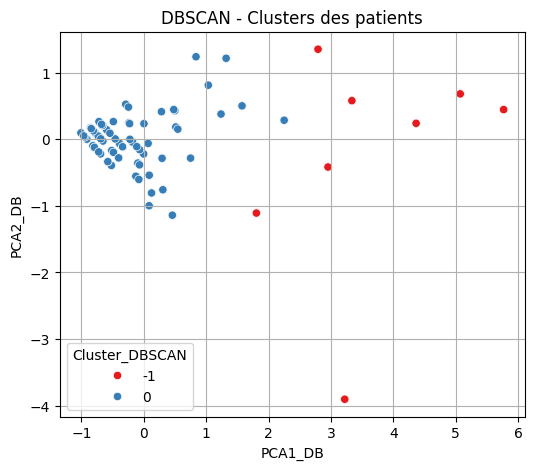

DBSCAN - Nombre de clusters détectés : 1
DBSCAN - Nombre de points considérés comme bruit (outliers) : 16


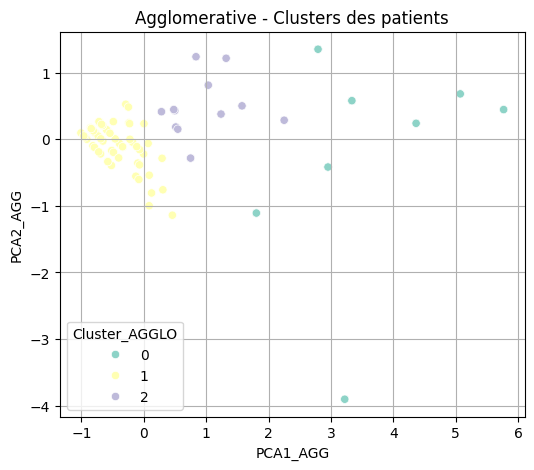

Agglomerative - Moyennes par cluster :
               Total_Cost  ICU_Stay
Cluster_AGGLO                      
0               574893.75     18.75
1                77919.87      1.50
2               183545.83     10.17
KMeans → Pseudo-R²: 0.7373 | MAE: 0.3366
DBSCAN → Pseudo-R²: 0.5998 | MAE: 0.4423
Agglomerative → Pseudo-R²: 0.7284 | MAE: 0.3414

✅ Algorithme le plus performant :
KMeans avec un pseudo-R² de 0.7373 et un MAE de 0.3366


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain t

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Connexion à PostgreSQL
USERNAME = os.getenv("POSTGRES_USER", "postgres")
PASSWORD = os.getenv("POSTGRES_PASSWORD", "123456789")
HOST = os.getenv("POSTGRES_HOST", "localhost")
PORT = os.getenv("POSTGRES_PORT", "5432")
DATABASE = os.getenv("POSTGRES_DB", "DBM")

DATABASE_URL = f"postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
engine = create_engine(DATABASE_URL, connect_args={'client_encoding': 'LATIN1'})

# Lecture des données
df = pd.read_sql('SELECT * FROM "FACT_FINANCE"', engine)
df = df[["PK_Patient", "Total_Cost", "ICU_Stay"]].dropna()
df = df[(df["Total_Cost"] < 1_000_000) & (df["ICU_Stay"] < 100)]

# Standardisation
features = ["Total_Cost", "ICU_Stay"]
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

# Fonction de calcul des métriques
def compute_metrics(df_scaled, features, labels, algo_name):
    df_temp = df_scaled.copy()
    df_temp["Cluster"] = labels

    # Moyenne globale
    global_mean = df_temp[features].mean()

    # Centroides par cluster
    centroids = df_temp.groupby("Cluster")[features].mean()

    # MAE
    errors = []
    for i, row in df_temp.iterrows():
        centroid = centroids.loc[row["Cluster"]]
        error = np.abs(row[features] - centroid).mean()
        errors.append(error)
    mae = np.mean(errors)

    # SSE = Somme des carrés intra-cluster
    sse = 0
    for i, row in df_temp.iterrows():
        centroid = centroids.loc[row["Cluster"]]
        sse += np.sum((row[features] - centroid) ** 2)

    # SST = Somme des carrés par rapport à la moyenne globale
    sst = np.sum((df_temp[features] - global_mean) ** 2).sum()

    # Pseudo R²
    r2 = 1 - (sse / sst)

    print(f"{algo_name} → Pseudo-R²: {r2:.4f} | MAE: {mae:.4f}")
    return {"algo": algo_name, "r2": r2, "mae": mae}

# -------------------- K-MEANS --------------------
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode du coude (KMeans)")
plt.grid()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
df_scaled["Cluster_KMeans"] = kmeans.fit_predict(df_scaled)

pca = PCA(n_components=2)
df_scaled[["PCA1_K", "PCA2_K"]] = pca.fit_transform(df_scaled[features])

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_scaled, x="PCA1_K", y="PCA2_K", hue="Cluster_KMeans", palette="Set2")
plt.title("KMeans - Clusters des patients")
plt.grid()
plt.show()

df_kmeans = pd.concat([df.reset_index(drop=True), df_scaled["Cluster_KMeans"]], axis=1)
print("KMeans - Moyennes par cluster :")
print(df_kmeans.groupby("Cluster_KMeans")[["Total_Cost", "ICU_Stay"]].mean().round(2))

# -------------------- DBSCAN --------------------
dbscan = DBSCAN(eps=0.8, min_samples=10)
df_scaled["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled[features])

pca = PCA(n_components=2)
df_scaled[["PCA1_DB", "PCA2_DB"]] = pca.fit_transform(df_scaled[features])

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_scaled, x="PCA1_DB", y="PCA2_DB", hue="Cluster_DBSCAN", palette="Set1")
plt.title("DBSCAN - Clusters des patients")
plt.grid()
plt.show()

n_clusters = len(set(df_scaled["Cluster_DBSCAN"])) - (1 if -1 in df_scaled["Cluster_DBSCAN"].values else 0)
n_noise = list(df_scaled["Cluster_DBSCAN"]).count(-1)
print(f"DBSCAN - Nombre de clusters détectés : {n_clusters}")
print(f"DBSCAN - Nombre de points considérés comme bruit (outliers) : {n_noise}")

# -------------------- AGGLOMERATIVE CLUSTERING --------------------
agglo = AgglomerativeClustering(n_clusters=3)
df_scaled["Cluster_AGGLO"] = agglo.fit_predict(df_scaled[features])

pca = PCA(n_components=2)
df_scaled[["PCA1_AGG", "PCA2_AGG"]] = pca.fit_transform(df_scaled[features])

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_scaled, x="PCA1_AGG", y="PCA2_AGG", hue="Cluster_AGGLO", palette="Set3")
plt.title("Agglomerative - Clusters des patients")
plt.grid()
plt.show()

df_agglo = pd.concat([df.reset_index(drop=True), df_scaled["Cluster_AGGLO"]], axis=1)
print("Agglomerative - Moyennes par cluster :")
print(df_agglo.groupby("Cluster_AGGLO")[["Total_Cost", "ICU_Stay"]].mean().round(2))

# -------------------- ÉVALUATION COMPARATIVE --------------------
results = []
results.append(compute_metrics(df_scaled, features, df_scaled["Cluster_KMeans"], "KMeans"))
results.append(compute_metrics(df_scaled, features, df_scaled["Cluster_DBSCAN"], "DBSCAN"))
results.append(compute_metrics(df_scaled, features, df_scaled["Cluster_AGGLO"], "Agglomerative"))

# Tri et interprétation
df_results = pd.DataFrame(results)
best = df_results.sort_values(by=["r2", "mae"], ascending=[False, True]).iloc[0]

print("\n✅ Algorithme le plus performant :")
print(f"{best['algo']} avec un pseudo-R² de {best['r2']:.4f} et un MAE de {best['mae']:.4f}")
